In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
accounts = pd.read_csv("archive/ravenstack_accounts.csv")
subscriptions = pd.read_csv("archive/ravenstack_subscriptions.csv")
churn_events = pd.read_csv("archive/ravenstack_churn_events.csv")

In [3]:
accounts['signup_date'] = pd.to_datetime(accounts['signup_date'])
churn_events['churn_date'] = pd.to_datetime(churn_events['churn_date'])

In [11]:
print("COHORT ANALYSIS")
print("")

last_churn_date = churn_events['churn_date'].max()
analysis_date = last_churn_date + pd.Timedelta(days=1)

print(f"Last churn date: {last_churn_date.date()}")
print(f"Analysis date: {analysis_date.date()}")
print("")

accounts['cohort_month'] = accounts['signup_date'].dt.to_period('M')

accounts_with_churn = accounts.merge(
    churn_events[['account_id', 'churn_date']], 
    on='account_id', 
    how='left'
)

def calculate_months_active(row):
    signup = row['signup_date']
    
    if pd.notna(row['churn_date']):
        end_date = row['churn_date']
    else:
        end_date = analysis_date
    
    months = (end_date.year - signup.year) * 12 + (end_date.month - signup.month)
    return max(0, months)

accounts_with_churn['months_active'] = accounts_with_churn.apply(calculate_months_active, axis=1)

print("Cohort data prepared")
print(f"  Cohorts: {accounts_with_churn['cohort_month'].nunique()}")
print(f"  Date range: {accounts_with_churn['cohort_month'].min()} to {accounts_with_churn['cohort_month'].max()}")
print("")

cohort_sizes = accounts_with_churn.groupby('cohort_month').size()

print("COHORT SIZES:")
for cohort, size in cohort_sizes.items():
    print(f"  {cohort}: {size} customers")
print("")

cohort_data = []

for cohort in accounts_with_churn['cohort_month'].unique():
    cohort_customers = accounts_with_churn[accounts_with_churn['cohort_month'] == cohort]
    cohort_size = len(cohort_customers)
    
    for month in range(25):
        still_active = (cohort_customers['months_active'] >= month).sum()
        retention_rate = (still_active / cohort_size) * 100
        
        cohort_data.append({
            'cohort': cohort,
            'month': month,
            'customers': still_active,
            'retention_rate': retention_rate
        })

cohort_df = pd.DataFrame(cohort_data)


cohort_pivot = cohort_df.pivot(index='cohort', columns='month', values='retention_rate')

print("SAMPLE RETENTION DATA (first 6 months):")
print(cohort_pivot.iloc[:5, :6].round(1))

COHORT ANALYSIS

Last churn date: 2024-12-31
Analysis date: 2025-01-01

Cohort data prepared
  Cohorts: 24
  Date range: 2023-01 to 2024-12

COHORT SIZES:
  2023-01: 23 customers
  2023-02: 24 customers
  2023-03: 32 customers
  2023-04: 20 customers
  2023-05: 39 customers
  2023-06: 21 customers
  2023-07: 21 customers
  2023-08: 25 customers
  2023-09: 40 customers
  2023-10: 33 customers
  2023-11: 34 customers
  2023-12: 29 customers
  2024-01: 26 customers
  2024-02: 18 customers
  2024-03: 43 customers
  2024-04: 31 customers
  2024-05: 34 customers
  2024-06: 32 customers
  2024-07: 38 customers
  2024-08: 29 customers
  2024-09: 41 customers
  2024-10: 41 customers
  2024-11: 50 customers
  2024-12: 24 customers

SAMPLE RETENTION DATA (first 6 months):
month        0      1      2      3     4     5
cohort                                         
2023-01  100.0   95.7   95.7   95.7  91.3  82.6
2023-02  100.0  100.0   91.7   87.5  87.5  83.3
2023-03  100.0   90.6   90.6   87.5 

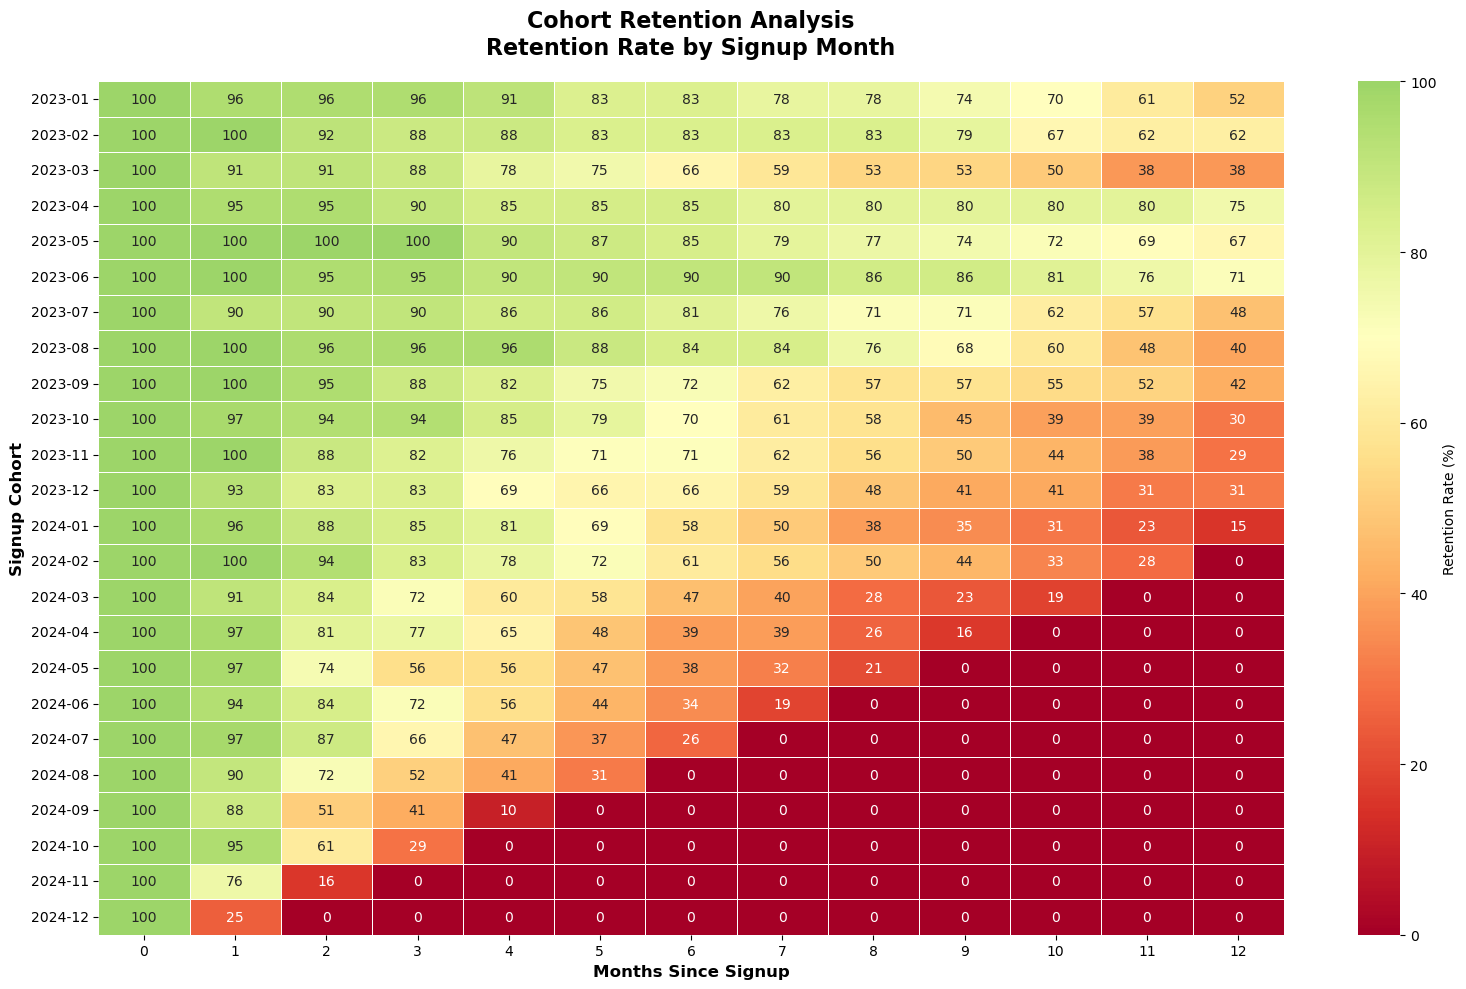

6-MONTH RETENTION BY COHORT:

  2023-06: 90.5%
  2023-04: 85.0%
  2023-05: 84.6%
  2023-08: 84.0%
  2023-02: 83.3%
  2023-01: 82.6%
  2023-07: 81.0%
  2023-09: 72.5%
  2023-11: 70.6%
  2023-10: 69.7%
  2023-03: 65.6%
  2023-12: 65.5%
  2024-02: 61.1%
  2024-01: 57.7%
  2024-03: 46.5%
  2024-04: 38.7%
  2024-05: 38.2%
  2024-06: 34.4%
  2024-07: 26.3%
  2024-08: 0.0%
  2024-09: 0.0%
  2024-10: 0.0%
  2024-11: 0.0%
  2024-12: 0.0%

Best cohort:  2023-06 (90.5%)
Worst cohort: 2024-08 (0.0%)
Difference: 90.5 percentage points

AVERAGE RETENTION CURVE:

  Month  0: 100.0%
  Month  1: 92.0%
  Month  3: 71.8%
  Month  6: 51.6%
  Month  9: 37.4%
  Month 12: 25.1%

MONTHLY CHURN RATE:

  Month 1: -8.0% drop
  Month 3: -7.7% drop
  Month 6: -5.7% drop
  Month 12: -4.2% drop

Cohort comparison complete.


In [13]:
fig, ax = plt.subplots(figsize=(16, 10))

cohort_pivot_12 = cohort_pivot.iloc[:, :13]

sns.heatmap(
    cohort_pivot_12, 
    annot=True, 
    fmt='.0f',
    cmap='RdYlGn',
    center=70,
    vmin=0,
    vmax=100,
    cbar_kws={'label': 'Retention Rate (%)'},
    linewidths=0.5,
    linecolor='white',
    ax=ax
)

ax.set_title('Cohort Retention Analysis\nRetention Rate by Signup Month', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Months Since Signup', fontsize=12, fontweight='bold')
ax.set_ylabel('Signup Cohort', fontsize=12, fontweight='bold')

y_labels = [str(label) for label in cohort_pivot_12.index]
ax.set_yticklabels(y_labels, rotation=0)

plt.tight_layout()
plt.show()

month_6_retention = cohort_pivot[6].sort_values(ascending=False)

print("6-MONTH RETENTION BY COHORT:")
print("")
for cohort, retention in month_6_retention.items():
    print(f"  {cohort}: {retention:.1f}%")
print("")

best_cohort = month_6_retention.idxmax()
worst_cohort = month_6_retention.idxmin()

print(f"Best cohort:  {best_cohort} ({month_6_retention[best_cohort]:.1f}%)")
print(f"Worst cohort: {worst_cohort} ({month_6_retention[worst_cohort]:.1f}%)")
print(f"Difference: {month_6_retention[best_cohort] - month_6_retention[worst_cohort]:.1f} percentage points")
print("")

print("AVERAGE RETENTION CURVE:")
print("")
avg_retention = cohort_pivot.mean(axis=0)

for month in [0, 1, 3, 6, 9, 12]:
    if month in avg_retention.index:
        print(f"  Month {month:2}: {avg_retention[month]:.1f}%")
print("")

print("MONTHLY CHURN RATE:")
print("")
for month in [1, 3, 6, 12]:
    if month in avg_retention.index and month-1 in avg_retention.index:
        churn = avg_retention[month-1] - avg_retention[month]
        print(f"  Month {month}: -{churn:.1f}% drop")
print("")

print("Cohort comparison complete.")

In [16]:
print("CRITICAL FINDINGS - 2024 DETERIORATION")
print("")

cohorts_2023 = [c for c in cohort_pivot.index if str(c).startswith('2023')]
cohorts_2024 = [c for c in cohort_pivot.index if str(c).startswith('2024')]

month_3_2023 = cohort_pivot.loc[cohorts_2023, 3].mean()
month_3_2024 = cohort_pivot.loc[cohorts_2024, 3].mean()

print("3-MONTH RETENTION:")
print(f"  2023 cohorts average: {month_3_2023:.1f}%")
print(f"  2024 cohorts average: {month_3_2024:.1f}%")
print(f"  Decline: {month_3_2023 - month_3_2024:.1f} percentage points")
print("")

month_6_2023 = cohort_pivot.loc[cohorts_2023, 6].mean()
month_6_2024 = cohort_pivot.loc[cohorts_2024[:-6], 6].mean()  # Only cohorts with 6 months data

print("6-MONTH RETENTION:")
print(f"  2023 cohorts average: {month_6_2023:.1f}%")
print(f"  2024 cohorts average: {month_6_2024:.1f}%")
print(f"  Decline: {month_6_2023 - month_6_2024:.1f} percentage points")
print("")

print("=" * 80)
print("WORST PERFORMING COHORTS")
print("=" * 80)
print("")

month_1_retention = cohort_pivot[1].sort_values()
print("LOWEST MONTH-1 RETENTION (immediate churn):")
for cohort in month_1_retention.head(5).index:
    retention = month_1_retention[cohort]
    loss = 100 - retention
    print(f"  {cohort}: {retention:.0f}% retained ({loss:.0f}% lost in first month)")
print("")

month_3_drop = (cohort_pivot[0] - cohort_pivot[3]).sort_values(ascending=False)
print("LARGEST 3-MONTH DROP:")
for cohort in month_3_drop.head(5).index:
    drop = month_3_drop[cohort]
    print(f"  {cohort}: {drop:.0f} percentage point drop")
print("")

print("=" * 80)
print("2024 MONTHLY TREND")
print("=" * 80)
print("")

print("First-month retention by 2024 cohort:")
for cohort in cohorts_2024:
    if 1 in cohort_pivot.columns:
        retention = cohort_pivot.loc[cohort, 1]
        loss = 100 - retention
        print(f"  {cohort}: {retention:.0f}% ({loss:.0f}% lost)")
print("")

q1_2024 = [c for c in cohorts_2024 if str(c) in ['2024-01', '2024-02', '2024-03']]
q2_2024 = [c for c in cohorts_2024 if str(c) in ['2024-04', '2024-05', '2024-06']]
q3_2024 = [c for c in cohorts_2024 if str(c) in ['2024-07', '2024-08', '2024-09']]
q4_2024 = [c for c in cohorts_2024 if str(c) in ['2024-10', '2024-11', '2024-12']]

if q1_2024:
    q1_loss = 100 - cohort_pivot.loc[q1_2024, 1].mean()
    print(f"Q1 2024 average first-month loss: {q1_loss:.1f}%")
if q2_2024:
    q2_loss = 100 - cohort_pivot.loc[q2_2024, 1].mean()
    print(f"Q2 2024 average first-month loss: {q2_loss:.1f}%")
if q3_2024:
    q3_loss = 100 - cohort_pivot.loc[q3_2024, 1].mean()
    print(f"Q3 2024 average first-month loss: {q3_loss:.1f}%")
if q4_2024:
    q4_loss = 100 - cohort_pivot.loc[q4_2024, 1].mean()
    print(f"Q4 2024 average first-month loss: {q4_loss:.1f}%")


CRITICAL FINDINGS - 2024 DETERIORATION

3-MONTH RETENTION:
  2023 cohorts average: 90.7%
  2024 cohorts average: 52.8%
  Decline: 38.0 percentage points

6-MONTH RETENTION:
  2023 cohorts average: 77.9%
  2024 cohorts average: 46.1%
  Decline: 31.8 percentage points

WORST PERFORMING COHORTS

LOWEST MONTH-1 RETENTION (immediate churn):
  2024-12: 25% retained (75% lost in first month)
  2024-11: 76% retained (24% lost in first month)
  2024-09: 88% retained (12% lost in first month)
  2024-08: 90% retained (10% lost in first month)
  2023-07: 90% retained (10% lost in first month)

LARGEST 3-MONTH DROP:
  2024-12: 100 percentage point drop
  2024-11: 100 percentage point drop
  2024-10: 71 percentage point drop
  2024-09: 59 percentage point drop
  2024-08: 48 percentage point drop

2024 MONTHLY TREND

First-month retention by 2024 cohort:
  2024-01: 96% (4% lost)
  2024-02: 100% (0% lost)
  2024-03: 91% (9% lost)
  2024-04: 97% (3% lost)
  2024-05: 97% (3% lost)
  2024-06: 94% (6% los

CRITICAL FINDING
RavenStack experienced catastrophic retention collapse in Q4 2024.

KEY EVIDENCE
Q4 2024 Collapse

Q1-Q2 2024: 4% first-month churn (acceptable)
Q3 2024: 8% first-month churn (warning)
Q4 2024: 35% first-month churn (catastrophic)
December 2024: 75% first-month churn

Year-over-Year Decline

2023 cohorts: 91% retention at 3 months
2024 cohorts: 53% retention at 3 months
Decline: 38 percentage points

December 2024 Disaster

75% of customers left in first month
100% churn by month 3
Complete onboarding failure


ROOT CAUSES

Product quality deterioration (scaling issues, bugs)
Onboarding breakdown (Q4 complete failure)
Customer success overwhelmed (cannot handle volume)
Possible external factors (competitors, pricing, reviews)


BUSINESS IMPACT
Q4 2024 estimated loss:

Customers lost: ~35% of new signups
Revenue impact: Significant first-month churn
December cohort: 75% immediate loss


URGENT ACTIONS
Immediate:

Emergency product quality audit
Identify what changed in Q4 2024
Interview surviving customers

Week 2-4:
4. Fix critical issues
5. Rebuild onboarding
6. Expand customer success team
Without action: Q1 2025 will be worse, company survival at risk.